<a href="https://colab.research.google.com/github/rerebebeccacca/20210624-deep-learning-class/blob/main/02face_identification_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!pip install mtcnn
# !pip uninstall h5py
!pip install h5py==2.10.0

     |████████████████████████████████| 2.3MB 8.1MB/s 
     |████████████████████████████████| 2.9MB 7.5MB/s 
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [3]:
# Download and unzip dataset
!gdown --id 1RJ6MEDV9tYexOTAQDiWZ2bx8fO4HuUAu
!unzip -q "5celeb.zip"

Downloading...
From: https://drive.google.com/uc?id=1RJ6MEDV9tYexOTAQDiWZ2bx8fO4HuUAu
To: /content/5celeb.zip
2.73MB [00:00, 85.6MB/s]


In [4]:
import mtcnn
from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K

In [5]:
FOLDER_PATH = '.'
IMG_SIZE = 160

In [6]:
detector = MTCNN()
path_train = sorted(glob(os.path.join(FOLDER_PATH, '5celeb/data/train/*/*.jpg')))
path_val = sorted(glob(os.path.join(FOLDER_PATH, '5celeb/data/val/*/*.jpg')))
len(path_train), len(path_val)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


(93, 25)

In [7]:
# extract names
names = []
for path in path_train:
    name = path.split(os.sep)[-2]
    if name not in names:
        names.append(name)
names

['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']

In [8]:
#build class map
cls_map = {}
for i, name in enumerate(names):
    cls_map[name] = int(i)
cls_map

{'ben_afflek': 0,
 'elton_john': 1,
 'jerry_seinfeld': 2,
 'madonna': 3,
 'mindy_kaling': 4}

In [9]:
# load X(img), y(labels)
def load_data(paths):
    X = np.zeros((len(paths), IMG_SIZE, IMG_SIZE, 3))
    y = np.zeros((len(paths), 1), dtype=int)
    for i, path in enumerate(tqdm(paths)):
        img = cv2.imread(path)[:,:,::-1]
        results = detector.detect_faces(img)
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        patch = img[max(y1, 0): min(y2, img.shape[0]), max(x1, 0): min(x2, img.shape[1])]
        # resize face
        patch = cv2.resize(patch, (IMG_SIZE, IMG_SIZE))
        name = path.split('/')[-2]
        X[i] = patch
        y[i] = cls_map[name]
    return X, y

In [10]:
X_train, y_train = load_data(path_train)
X_val, y_val = load_data(path_val)

### Preprocess

In [11]:
X_train = X_train / 255.
X_val = X_val / 255.

[0] ben_afflek


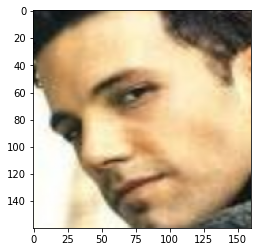

[0] ben_afflek


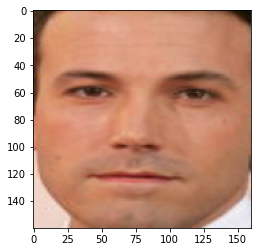

[0] ben_afflek


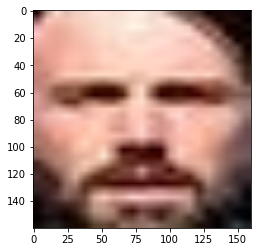

[0] ben_afflek


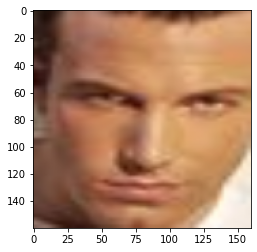

[0] ben_afflek


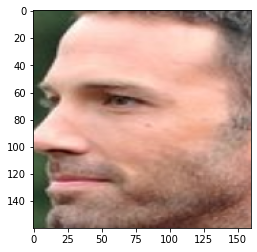

In [12]:
for i in range(X_train.shape[0])[:5]:
    print(y_train[i], names[y_train[i][0]])
    plt.imshow(X_train[i])
    plt.show()

In [13]:
def create_pairs(x, face_indices, num_classes):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(face_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            # positive pairs
            z1, z2 = face_indices[d][i], face_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            # negative pairs
            inc = np.random.randint(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = face_indices[d][i], face_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

# create training+test positive and negative pairs
face_indices = [np.where(y_train == i)[0] for i in range(len(names))]
train_pairs, train_y = create_pairs(X_train, face_indices, num_classes=len(names))

face_indices = [np.where(y_val == i)[0] for i in range(len(names))]
val_pairs, val_y = create_pairs(X_val, face_indices, num_classes=len(names))

In [14]:
train_pairs.shape, train_y.shape, val_pairs.shape, val_y.shape

((130, 2, 160, 160, 3), (130,), (40, 2, 160, 160, 3), (40,))

In [15]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [17]:
# build model
# network definition
base_network = keras.applications.resnet50.ResNet50(include_top=False, 
                                                    weights=None, 
                                                    input_shape=(IMG_SIZE, IMG_SIZE, 3))
#送進兩個圖
input_a = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
input_b = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
global_avg = GlobalAveragePooling2D()
processed_a = base_network(input_a)
processed_a = global_avg(processed_a)
processed_b = base_network(input_b)
processed_b = global_avg(processed_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [18]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 5, 5, 2048)   23587712    input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           resnet50[1][0]             

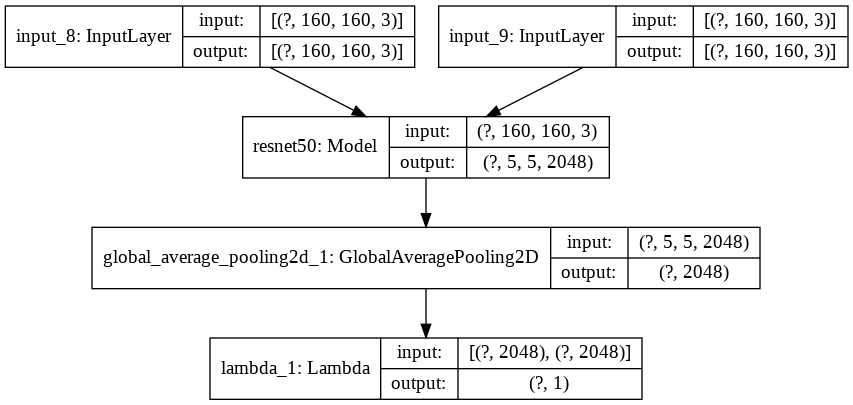

In [19]:
plot_model(model, show_shapes=True)

In [20]:
earlystop = EarlyStopping(patience=10)
model_ckp = ModelCheckpoint(os.path.join('model_siamese.h5'), save_best_only=True, save_weights_only=False)

# train
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[])
model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y,
          batch_size=32,
          epochs=1000,
          callbacks=[earlystop, model_ckp],
          validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 130 samples, validate on 40 samples
Epoch 1/1000
130/130 [==============================] - 25s 192ms/sample - loss: 111.5641 - val_loss: 0.3512
Epoch 2/1000
130/130 [==============================] - 2s 16ms/sample - loss: 36.0624 - val_loss: 0.3594
Epoch 3/1000
130/130 [==============================] - 2s 15ms/sample - loss: 14.7728 - val_loss: 0.3686
Epoch 4/1000
130/130 [==============================] - 2s 15ms/sample - loss: 6.7348 - val_loss: 0.3723
Epoch 5/1000
130/130 [==============================] - 2s 15ms/sample - loss: 3.3953 - val_loss: 0.3728
Epoch 6/1000
130/130 [==============================] - 2s 15ms/sample - loss: 1.9049 - val_loss: 0.3727
Epoch 7/1000
130/130 [==============================] - 2s 15ms/sample - loss: 1.1781 - val_loss: 0.3685
Epoch 8/1000
130/130 [==============================] - 2s 15ms/sample - loss: 0.8130 - val_loss: 0.3665
Epoch 9/1000
13

In [21]:
#Download pretrained model
!gdown --id 1JCo1g2sBkG-CwBbqOYlZ1KdGvRcjKTYV -O model.h5

Downloading...
From: https://drive.google.com/uc?id=1JCo1g2sBkG-CwBbqOYlZ1KdGvRcjKTYV
To: /content/model.h5
283MB [00:01, 204MB/s]


In [22]:
# load model
# method1: compile=False
# model = load_model('model.h5', compile=False)
# method 2
model = load_model('model.h5', custom_objects={'contrastive_loss': contrastive_loss})

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


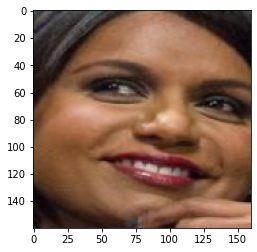

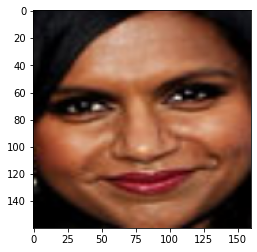

label:  1  val data shape:  (1, 2, 160, 160, 3)
Distance:  [[0.7307819]]


In [23]:
# Evaluation
idx = np.random.randint(0, val_pairs.shape[0])
pair = val_pairs[idx]
label = val_y[idx]
imgA, imgB = pair[0], pair[1]
plt.imshow(imgA)
plt.show()
plt.imshow(imgB)
plt.show()
print('label: ', label, ' val data shape: ',val_pairs[idx:idx+1].shape)
print('Distance: ', model.predict([np.expand_dims(imgA, axis=0), np.expand_dims(imgB, axis=0)]))

In [24]:
all_pairs = np.concatenate((train_pairs, val_pairs))
all_labels = np.concatenate((train_y, val_y))

In [25]:
positive_pairs = all_pairs[all_labels == 1]
negative_pairs = all_pairs[all_labels == 0]

In [26]:
positive_distances = model.predict([positive_pairs[:, 0], positive_pairs[:, 1]])
negative_distances = model.predict([negative_pairs[:, 0], negative_pairs[:, 1]])

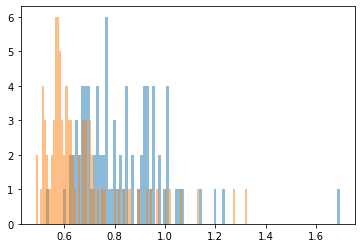

In [27]:
plt.hist(negative_distances[:,0], bins=100, alpha=0.5)
plt.hist(positive_distances[:,0], bins=100, alpha=0.5)
plt.show()